In [80]:
import numpy as np
import matplotlib.pyplot as plt
from utils import uniform_shell_sampler, make_nice_plots
from scipy import stats
from tqdm import tqdm

make_nice_plots()


In [ ]:
def dVdr_prior(rcom, rmax):
    '''Uniform in volume distribution on radius, normalized between 0 and rmax.'''
    return np.where(rcom > rmax, rcom**2 / rmax**3 * 3, 0)


In [117]:
RMIN = 0
RDRAW = 100
RMAX = 100
NAGN = int(1e3)
NGW_ALT = int(1e3)
NGW_AGN = int(1e3)
N_MC_SAMPS = int(1e4)
GW_RCOM_ERR = 0.1
rr = np.linspace(RMIN, RMAX, 1000)
chunk = int(100)

assert (NGW_ALT >= chunk) & (NGW_AGN >= chunk), 'Too few GWs causes error in chunking'


In [118]:
# AGN catalog

agn_pos, _, _ = uniform_shell_sampler(RMIN, RMAX, NAGN)
agn_below_thresh = agn_pos[agn_pos < RDRAW]
nagn_below_thesh = len(agn_below_thresh)

In [119]:
# GWs & likelihood

true_pos_gw_alt, _, _ = uniform_shell_sampler(RMIN, RDRAW, NGW_ALT)
true_pos_gw_agn = np.random.choice(agn_below_thresh, NGW_AGN)

obs_pos_gw_alt = np.random.normal(loc=true_pos_gw_alt, scale=GW_RCOM_ERR)
obs_pos_gw_agn = np.random.normal(loc=true_pos_gw_agn, scale=GW_RCOM_ERR)

p_agn_alt_gws = np.zeros(NGW_ALT)
p_agn_agn_gws = np.zeros(NGW_AGN)
p_alt_alt_gws = np.zeros(NGW_ALT)
p_alt_agn_gws = np.zeros(NGW_AGN)
chunk = 100
for i in tqdm(range(int(NGW_AGN / chunk))):  # Chunking to keep #mc samps x #gws <= 1e6 for memory usage
    start, stop = int(i * chunk), int((i + 1) * chunk)

    posterior_alt_gws = lambda x: stats.norm.pdf(x, loc=obs_pos_gw_alt[start:stop], scale=GW_RCOM_ERR)
    posterior_agn_gws = lambda x: stats.norm.pdf(x, loc=obs_pos_gw_agn[start:stop], scale=GW_RCOM_ERR)

    p_agn_alt_gws[start:stop] = np.sum( posterior_alt_gws(agn_below_thresh[:,np.newaxis]), axis=0 ) / nagn_below_thesh
    p_agn_agn_gws[start:stop] = np.sum( posterior_agn_gws(agn_below_thresh[:,np.newaxis]), axis=0 ) / nagn_below_thesh

    mc_samps_alt = np.random.normal(loc=true_pos_gw_alt[start:stop], scale=GW_RCOM_ERR, size=(N_MC_SAMPS, chunk))
    mc_samps_agn = np.random.normal(loc=true_pos_gw_agn[start:stop], scale=GW_RCOM_ERR, size=(N_MC_SAMPS, chunk))

    p_alt_alt_gws[start:stop] = np.sum( dVdr_prior(mc_samps_alt, RMAX), axis=0) / N_MC_SAMPS
    p_alt_agn_gws[start:stop] = np.sum( dVdr_prior(mc_samps_agn, RMAX), axis=0) / N_MC_SAMPS


100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


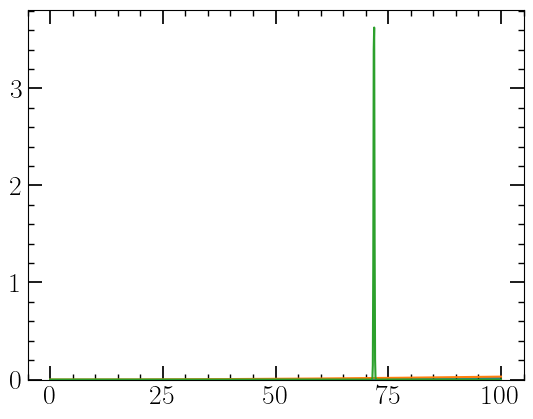

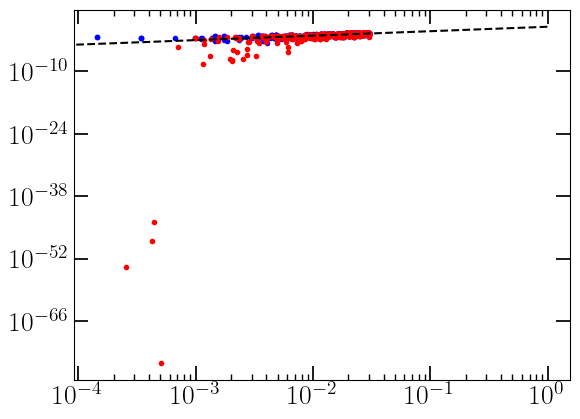

In [120]:
plt.figure()
plt.hist(agn_pos, bins=30, density=True)
plt.plot(rr, dVdr_prior(rr, RMAX))
plt.plot(rr, posterior_alt_gws(rr[:,np.newaxis])[:,0])
plt.show()

plt.figure()
plt.scatter(p_alt_agn_gws, p_agn_agn_gws, color='blue', marker='.')
plt.scatter(p_alt_alt_gws, p_agn_alt_gws, color='red', marker='.')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color='black', linestyle='dashed')
plt.loglog()
plt.show()


100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


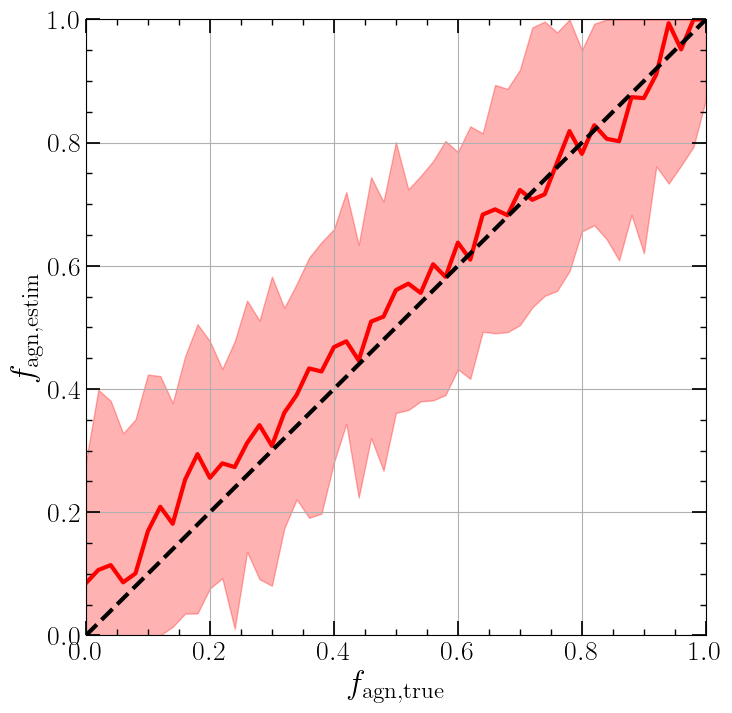

In [121]:
### Some translations to reuse my code ###
cw_pagn = np.append(p_agn_agn_gws, p_agn_alt_gws)
cw_palt = np.append(p_alt_agn_gws, p_alt_alt_gws)
palt = cw_palt  # c = 1
agn_events = np.ones(int(NGW_AGN + NGW_ALT), dtype=bool)
agn_events[NGW_AGN:] = 0
alt_events = ~agn_events
##########################################

use_N_gws = 100
max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 0.9999, calc_logllh_at_N_points)
n_trials = 100
gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn

if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):
    print('Chunking...')

estimation_arr = np.zeros((n_trials, N_true_fagns))
for trial_idx in tqdm(range(n_trials)):
    ## These two lines are for making the underlying truth equal to the actual realization of that truth
    # use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
    # true_fagns = use_N_agn_events / use_N_gws
    
    ## Otherwise, use these two
    true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn

    use_N_alt_events = use_N_gws - use_N_agn_events
    realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    agn_idx = np.random.choice(np.where(agn_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
    alt_idx = np.random.choice(np.where(alt_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
    idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

    fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]
    total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
    total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
    total_prob_alt = palt[idx].T[np.newaxis,...]

    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):  # Chunking to avoid too large arrays in memory

        log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
        for i in range(int(use_N_gws / gw_chunk_size)):
            gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
            cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
            cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
            alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

            for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
                llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
                fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
                fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
                fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
                alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

                log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
                log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
    else:
        log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
        log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )  

    log_llh_denominator = 0  # TODO: GW selection effects
    log_llh = log_llh_numerator - log_llh_denominator
    estimation_arr[trial_idx, :] = log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

fagn_medians = np.median(estimation_arr, axis=0)
q016 = np.quantile(estimation_arr, 0.16, axis=0)
q084 = np.quantile(estimation_arr, 0.84, axis=0)

plt.figure(figsize=(8,8))
plt.plot(true_fagns, fagn_medians, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.fill_between(true_fagns, q016, q084, color='red', alpha=0.3)
plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
